In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

<h1> Prepare data </h1>

<h5> Load Excel file as dataframes </h5>

In [2]:
invoices = pd.read_excel('sales_original.xlsx', sheet_name = 'invoices')
assessment = pd.read_excel('sales_original.xlsx', sheet_name = 'assessment')
customers = pd.read_excel('sales_original.xlsx', sheet_name = 'customers')
products = pd.read_excel('sales_original.xlsx', sheet_name = 'products')
stock = pd.read_excel('sales_original.xlsx', sheet_name = 'stock')

We cleaned the individual dataframes for our SQL queries. <br>
But for the EDA, we want to use all of the data. Sometimes the dropped duplicate rows or null values may still hold important information. <br>

The way these dataframes were created was: each row in each excel spread corresponds to the same row in all the other spreads. <br>
So we will concatenate along the row axis.


In [3]:
merged_table = pd.concat([invoices, assessment, customers, products, stock], axis = 1)

In [4]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,ASIN,CustomerID,Country,ASIN,title,product_type,StockCode,ASIN
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,B07GWKDLGT,18011,Germany,B07GWKDLGT,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,B07GWKDLGT
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,B01MTLH408,18011,Germany,B01MTLH408,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,B01MTLH408


In [5]:
merged_table.columns

Index(['InvoiceNo', 'ASIN', 'Quantity', 'price', 'total_sale', 'invoice_date',
       'invoice_time', 'CustomerID', 'rating', 'review_count', 'ASIN',
       'CustomerID', 'Country', 'ASIN', 'title', 'product_type', 'StockCode',
       'ASIN'],
      dtype='object')

Drop duplicate columns

In [6]:
merged_table.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True])

In [7]:
merged_table = merged_table.loc[:, ~merged_table.columns.duplicated()]

In [8]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,Country,title,product_type,StockCode
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001


Relabel columns 

In [9]:
merged_table = merged_table.rename(columns = {'InvoiceNo': 'invoice_no', 'ASIN':'product_id', 'Quantity': 'quantity', 'price': 'unit_price', 
                                'CustomerID': 'customer_id', 'Country': 'country', 'title':'product_name', 'StockCode': 'stock_code'})

Combine "invoice_date" + "invoice_time" as "invoice_datetime"

In [10]:
merged_table['invoice_datetime'] = merged_table['invoice_date'] + merged_table['invoice_time'].astype('timedelta64[h]')
merged_table = merged_table.drop(['invoice_date', 'invoice_time'], axis = 1)

In [11]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00


In [12]:
# Add "day_of_week" column
merged_table['day_of_week'] = merged_table['invoice_datetime'].dt.dayofweek # 0 = Monday, 1 = Tuesday, etc.

# Add "month" column
merged_table['month'] = merged_table['invoice_datetime'].dt.month

# Add "hour" column
merged_table['hour'] = merged_table['invoice_datetime'].dt.hour

# Add "year" column
merged_table['year'] = merged_table['invoice_datetime'].dt.year

# Add "quarter" column
merged_table['quarter'] = merged_table['invoice_datetime'].dt.quarter


In [13]:
merged_table['invoice_date'] = merged_table['invoice_datetime'].dt.date

Save the dataframe as csv

In [14]:
merged_table.to_csv('merged_table', index = False)

In [15]:
#excel_writer = pd.ExcelWriter('file_name_123.xlsx', engine = 'xlsxwriter', date_format='YYYY-MM-DD')
merged_table.to_excel('sales_date_cleaned.xlsx', sheet_name = 'Sheet1', index=False)

<h3> EDA </h3>

In [16]:
merged_table = pd.read_csv('merged_table', parse_dates = ['invoice_datetime'])

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


<h3> Overview of data </h3> 

In [18]:
num_countries = merged_table['country'].nunique()
num_registered_customers = merged_table[merged_table['customer_id']!= 'Null']['customer_id'].nunique()
num_orders_unregistered_customers = merged_table[merged_table['customer_id']== 'Null']['invoice_no'].nunique()
num_orders_registered_customers = merged_table[merged_table['customer_id']!= 'Null']['invoice_no'].nunique()
num_product_types = merged_table['product_type'].nunique()
num_products = merged_table['product_id'].nunique()
num_rows = len(merged_table)
num_orders= merged_table['invoice_no'].nunique()

num_countries, num_registered_customers, num_orders_unregistered_customers, num_orders_registered_customers, num_product_types, num_products, num_rows, num_orders

(37, 4339, 2053, 18570, 6, 4134, 554417, 20623)

In [19]:
merged_table[merged_table['customer_id']== 'Null']['invoice_no'].nunique()

2053

In [20]:
merged_table

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
2,78536597,B0064FS7HI,1,12.99,12.99,18011,4.4,333,Germany,"STK LP-E8 Battery for Canon Rebel T5i, T3i, T2...",dslr camera,85034A,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
3,78536597,B013JHU5YG,1,199.99,199.99,18011,4.3,86,Germany,Lowepro Whistler BP 350 AW (Grey) . Profession...,dslr camera,72798C,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
4,78536597,B06XWN9Q99,1,7.49,7.49,18011,4.7,15717,Germany,Samsung (MB-ME32GA/AM) 32GB 95MB/s (U1) microS...,dslr camera,20726,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554412,78581476,B00SB6SPA2,12,14.99,179.88,12433,4.0,3159,Norway,AUSDOM Lightweight Over-Ear Wired HiFi Stereo ...,smartphone,23243,2019-12-09 08:00:00,0,12,8,2019,4,2019-12-09
554413,78581476,B07TKTRX6B,6,29.99,179.94,12433,3.7,1888,Norway,"Squish Qi Wireless Car Charger, Wireless Charg...",smartphone,23240,2019-12-09 08:00:00,0,12,8,2019,4,2019-12-09
554414,78581475,B07P8CK47X,12,6.97,83.64,13069,4.5,449,Germany,"Cell Phone Stand, 2Pack Cellphone Holder for D...",smartphone,23235,2019-12-09 08:00:00,0,12,8,2019,4,2019-12-09
554415,78581475,B07BDGPDKS,20,13.99,279.80,13069,4.6,1368,Germany,USB Certified Type C Cable - EVISTR 3PACK 10FT...,smartphone,22380,2019-12-09 08:00:00,0,12,8,2019,4,2019-12-09


<h3> Customer buying pattern </h3>

<h4> Aggregated dataframes </h4>

Group by: 

- day_of_week <br>
- hour  <br>
- month <br>
- country <br>

- Note, the aggregated dataframes only consider 2019


In [21]:
# Group by day of week
df_dow = merged_table[merged_table['year'] == 2019].groupby(['day_of_week']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})

df_dow['num_orders']=df_dow['invoice_no']['nunique']
df_dow['total_sale_mean']=df_dow['total_sale']['mean']
df_dow['total_revenue']=df_dow['total_sale']['sum']
df_dow['num_unique_customers']= df_dow['customer_id']['nunique']
df_dow['units_sold_mean'] = df_dow['quantity']['mean']
df_dow['total_units_sold'] = df_dow['quantity']['sum']

df_dow = df_dow[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_dow = df_dow.reset_index()
# Tuesday data is missing, so add zero values.
df_dow.loc['6'] = [1,0,0,0,0]
df_dow = df_dow.sort_values('day_of_week')
df_dow.index = [0,1,2,3,4,5,6]


# Group by hour
df_hour = merged_table[merged_table['year'] == 2019].groupby(['hour']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_hour['num_orders']=df_hour['invoice_no']['nunique']
df_hour['total_sale_mean']=df_hour['total_sale']['mean']
df_hour['total_revenue']=df_hour['total_sale']['sum']
df_hour['num_unique_customers']= df_hour['customer_id']['nunique']
df_hour['units_sold_mean'] = df_hour['quantity']['mean']
df_hour['total_units_sold'] = df_hour['quantity']['sum']

df_hour = df_hour[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_hour = df_hour.reset_index()


# Group by month
df_month = merged_table[merged_table['year'] == 2019].groupby(['month']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_month['num_orders']=df_month['invoice_no']['nunique']
df_month['total_sale_mean']=df_month['total_sale']['mean']
df_month['total_revenue']=df_month['total_sale']['sum']
df_month['num_unique_customers']= df_month['customer_id']['nunique']
df_month['units_sold_mean'] = df_month['quantity']['mean']
df_month['total_units_sold'] = df_month['quantity']['sum']

df_month = df_month[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_month = df_month.reset_index()

# Group by invoice_date
df_date = merged_table[merged_table['year'] == 2019].groupby(['invoice_date']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_date['num_orders']=df_date['invoice_no']['nunique']
df_date['total_sale_mean']=df_date['total_sale']['mean']
df_date['total_revenue']=df_date['total_sale']['sum']
df_date['num_unique_customers']= df_date['customer_id']['nunique']
df_date['units_sold_mean'] = df_date['quantity']['mean']
df_date['total_units_sold'] = df_date['quantity']['sum']

df_date = df_date[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_date = df_date.reset_index()


# Group by country
df_country = merged_table[merged_table['year'] == 2019].groupby(['country']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_country['num_orders']=df_country['invoice_no']['nunique']
df_country['total_sale_mean']=df_country['total_sale']['mean']
df_country['total_revenue']=df_country['total_sale']['sum']
df_country['num_unique_customers']= df_country['customer_id']['nunique']
df_country['units_sold_mean'] = df_country['quantity']['mean']
df_country['total_units_sold'] = df_country['quantity']['sum']

df_country = df_country[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_country.sort_values(by = ['total_revenue', 'num_orders', 'num_unique_customers'],ascending = False, inplace = True)
df_country['revenue_per_customer'] = df_country['total_revenue'] / df_country['num_unique_customers']
df_country['revenue_per_order'] = df_country['total_revenue'] / df_country['num_orders']
df_country = df_country.reset_index()

# Group by customer

df_customer = merged_table.groupby(['customer_id']).agg({'invoice_no':'nunique', 'total_sale':'sum', 
                                                    'product_id': 'nunique', 'unit_price':'mean',
                                                     'quantity': ['mean', 'sum']})

df_customer['num_orders'] = df_customer['invoice_no']['nunique']
df_customer['total_revenue'] = df_customer['total_sale']['sum']
df_customer['num_unique_products'] = df_customer['product_id']['nunique']
df_customer['avg_unit_price'] = df_customer['unit_price']['mean']
df_customer['total_units_sold'] = df_customer['quantity']['sum']


df_customer = df_customer[['num_orders','total_revenue','num_unique_products','avg_unit_price','total_units_sold']].reset_index().sort_values(by='total_revenue',ascending=False)
df_customer.drop(4339, axis = 0,inplace = True) # drop row where customer_id = Null
df_customer.columns = [tup[0] for tup in df_customer.columns]
df_customer.columns
# We also want to add the customer country to df_customer. Do a left join.
dummy = merged_table[['customer_id', 'country']].drop_duplicates()
df_customer = pd.merge(df_customer, dummy, on = 'customer_id', how = 'left', copy = False)

<h3> Check all aggragated dataframes </h3>

In [22]:
df_dow.head()


,day_of_week,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,0,3047,8.833007e+07,1497,906148
1,1,0,0.000000e+00,0,0
2,2,2052,4.848538e+07,1181,459617
3,3,2993,8.981944e+07,1525,894923
4,4,3430,1.143019e+08,1649,1154448


In [23]:
df_hour.head()


,hour,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,6,1,279.00,1,1
1,7,27,1411814.09,26,15773
2,8,542,16959489.24,415,162761
3,9,1412,50196824.30,845,515716
4,10,2252,80975107.94,1199,843607


In [24]:
df_month.head()


,month,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,1,1100,38126912.27,742,407747
1,2,1108,29315803.02,759,300844
2,3,1496,42474432.75,975,422550
3,4,1276,32697661.49,855,328131
4,5,1707,41226715.35,1057,428100


In [25]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2019-01-04,39,1002201.60,35,9256
1,2019-01-05,55,1786655.03,46,20504
2,2019-01-06,50,2327005.04,46,24178
3,2019-01-07,53,2117371.08,46,17648
4,2019-01-09,48,1015109.82,48,8532


In [26]:
df_country.head()

,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
0,Germany,17248,4.808830e+08,3815,4731881,1.260506e+05,27880.506213
1,Netherlands,91,2.130295e+07,8,202159,2.662869e+06,234098.389121
2,Ireland,271,1.539087e+07,4,147902,3.847717e+06,56792.869336
3,United Kingdom,448,1.178792e+07,101,126310,1.167120e+05,26312.312589
4,France,368,1.109539e+07,85,111131,1.305340e+05,30150.524429


In [27]:
df_customer.head()

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold,country
0,14646,73,21664738.30,707,96.933489,205535,Netherlands
1,14911,201,9340224.33,1790,97.530018,83711,Ireland
2,12415,20,9244349.18,442,106.143735,80119,Australia
3,17450,46,9061246.11,123,97.376657,70185,Germany
4,18102,60,8114485.22,162,123.187740,72321,Germany


six dataframes: <br>
dow, month, hour, date, country, customer_id <br>

<h3> Day of week </h3>

In [28]:
df_dow

,day_of_week,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,0,3047,8.833007e+07,1497,906148
1,1,0,0.000000e+00,0,0
2,2,2052,4.848538e+07,1181,459617
3,3,2993,8.981944e+07,1525,894923
4,4,3430,1.143019e+08,1649,1154448
5,5,3566,1.052957e+08,1652,1034159
6,6,3963,1.290344e+08,1901,1200525


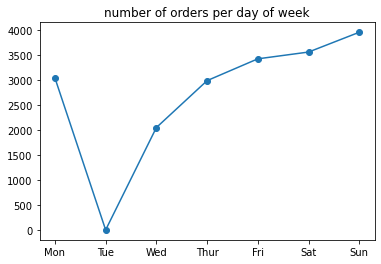

In [29]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['num_orders'], marker = 'o')
ax.set_title('number of orders per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.show()

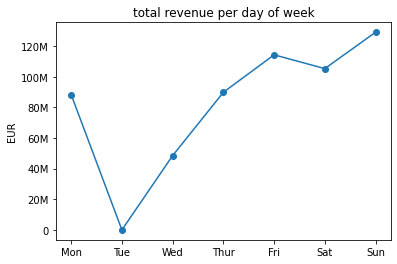

In [30]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['total_revenue'], marker = 'o')
ax.set_title('total revenue per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax.set_yticks(ticks = range(0,140000000, 20000000))
ax.set_yticklabels(labels = ['0', '20M', '40M', '60M', '80M', '100M', '120M'])
ax.set_ylabel('EUR')
plt.show()

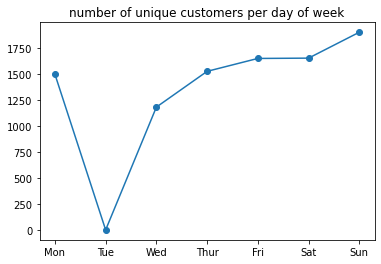

In [31]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['num_unique_customers'], marker = 'o')
ax.set_title('number of unique customers per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.show()

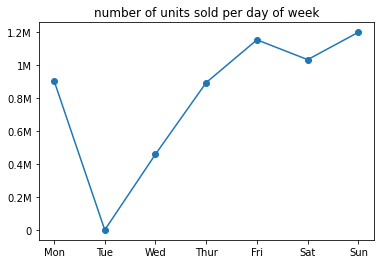

In [32]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['total_units_sold'], marker = 'o')
ax.set_title('number of units sold per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax.set_yticks(ticks = range(0,1400000, 200000))
ax.set_yticklabels(labels = ['0', '0.2M', '0.4M', '0.6M', '0.8M', '1M', '1.2M'])
plt.show()

<h3> Month </h3>

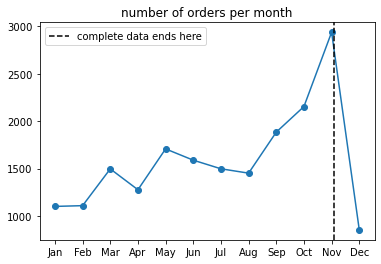

In [33]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['num_orders'], marker = 'o')
ax.axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax.set_title('number of orders per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend()
plt.show()

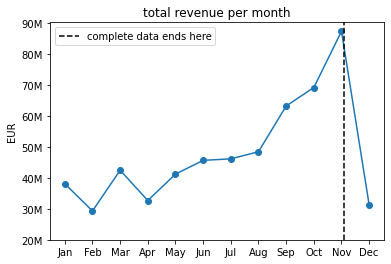

In [34]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['total_revenue'], marker = 'o')
ax.axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax.set_title('total revenue per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_yticks(ticks = list(range(20000000,90000001,10000000)))
ax.set_yticklabels(labels = ['20M', '30M', '40M', '50M', '60M', '70M', '80M', '90M'])
ax.set_ylabel('EUR')
ax.legend()
plt.show()

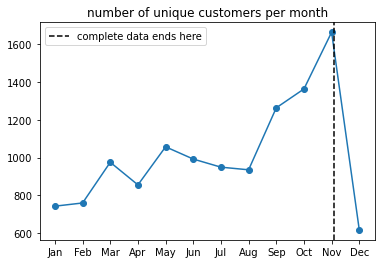

In [35]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['num_unique_customers'], marker = 'o')
ax.axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax.set_title('number of unique customers per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend()
plt.show()

/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_40156/2319191183.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = ['200k', '300k', '400k', '500k', '600k', '700k', '800k'])


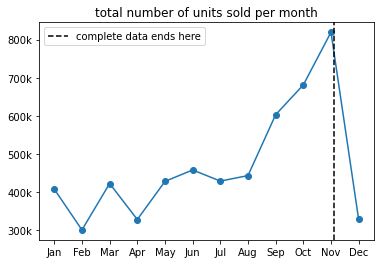

In [36]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['total_units_sold'], marker = 'o')
ax.axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax.set_title('total number of units sold per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_yticklabels(labels = ['200k', '300k', '400k', '500k', '600k', '700k', '800k'])
ax.legend()
plt.show()

<h3> Hour </h3>

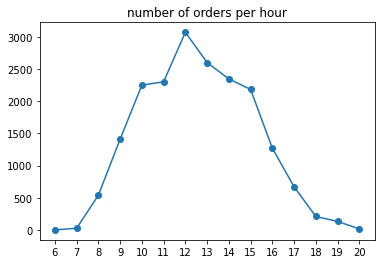

In [37]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['num_orders'], marker = 'o')
ax.set_title('number of orders per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
plt.show()

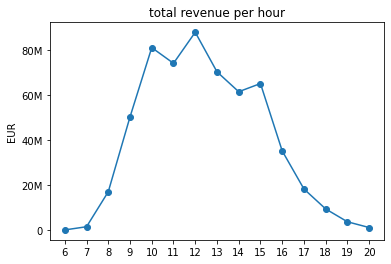

In [38]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['total_revenue'], marker = 'o')
ax.set_title('total revenue per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
ax.set_yticks(ticks = list(range(0,90000000, 20000000)))
ax.set_yticklabels(labels = ['0', '20M', '40M', '60M', '80M'])
ax.set_ylabel('EUR')
plt.show()

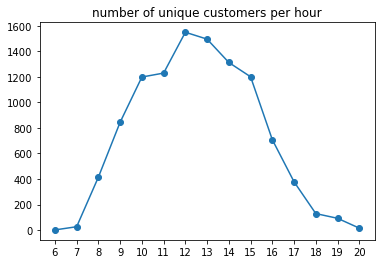

In [39]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['num_unique_customers'], marker = 'o')
ax.set_title('number of unique customers per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
plt.show()

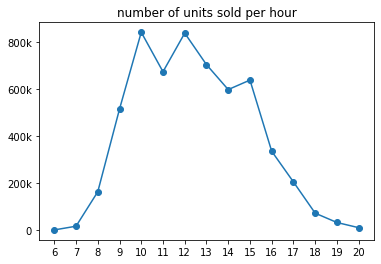

In [40]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['total_units_sold'], marker = 'o')
ax.set_title('number of units sold per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
ax.set_yticks(ticks = list(range(0,900000, 200000)))
ax.set_yticklabels(labels = ['0', '200k', '400k', '600k', '800k'])
plt.show()

<h3> Invoice date </h3>

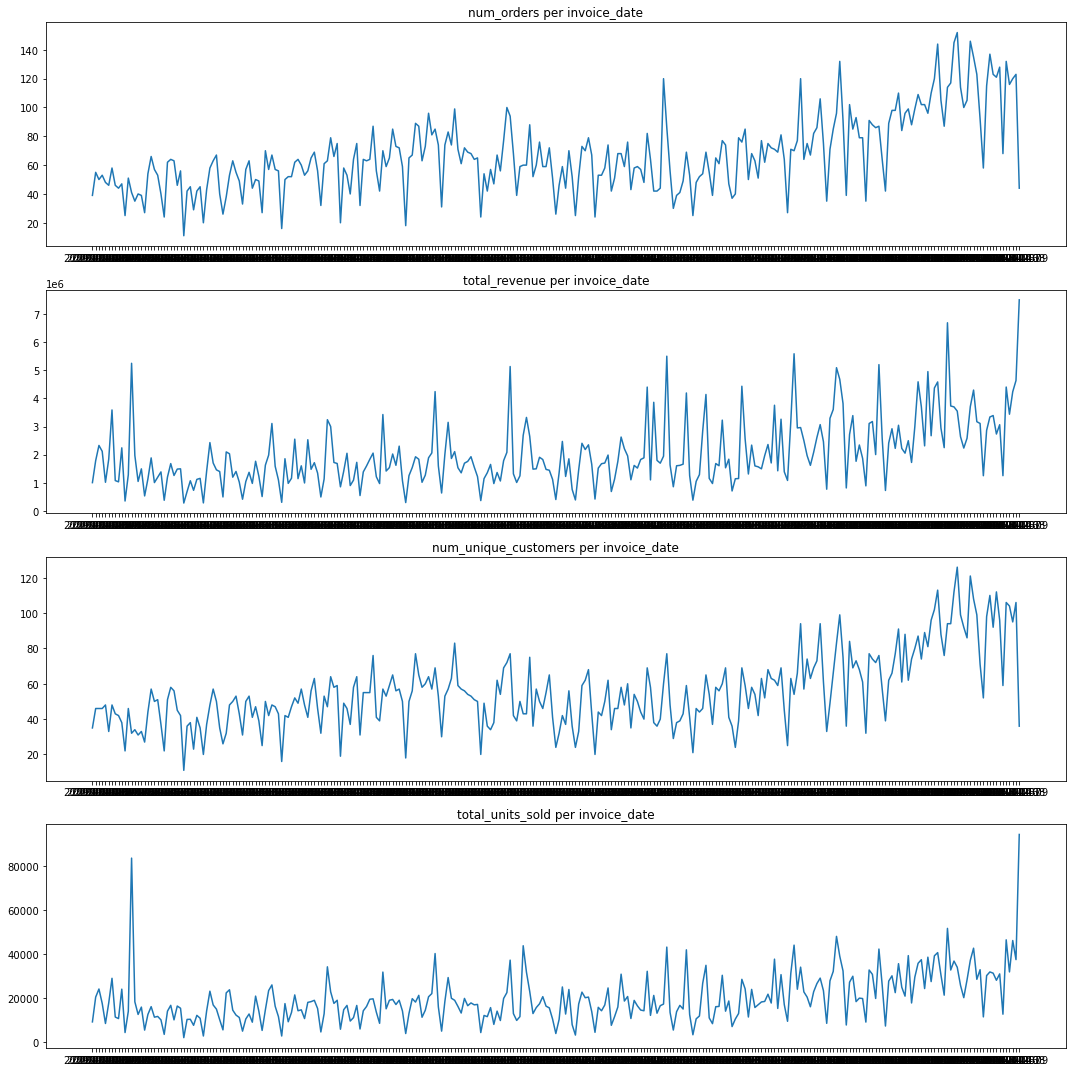

In [41]:
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (15,15))
for i, var in enumerate (variables):
    ax[i].plot(df_date['invoice_date'], df_date[var])
    ax[i].set_title (f'{var} per invoice_date')
    
plt.tight_layout()
plt.show()



<h3> Days in 2019 with unusual peaks and troughs in total_revenue </h3>

In [42]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2019-01-04,39,1002201.60,35,9256
1,2019-01-05,55,1786655.03,46,20504
2,2019-01-06,50,2327005.04,46,24178
3,2019-01-07,53,2117371.08,46,17648
4,2019-01-09,48,1015109.82,48,8532


To locate unusual peaks: <br>
Add column for the "rolling mean" and column for "total revenue - rolling mean"

In [43]:
df_date ['total_revenue_rolling_mean'] = df_date['total_revenue'].rolling(5, center= True).mean()       # mean of current date + previous date + following date
df_date['total_revenue_minus_mean'] = df_date ['total_revenue'] - df_date ['total_revenue_rolling_mean'] # current value - mean value

In [44]:
# Convert invoice_date column to datetime format
df_date['invoice_date'] = pd.to_datetime(df_date['invoice_date'])

In [45]:
# Select unusual peaks and troughs
high_rev_dates = df_date[(df_date['total_revenue_rolling_mean']!= 'NaN')&(df_date['total_revenue_minus_mean']/df_date['total_revenue_rolling_mean']>0.3)] 
low_rev_dates = df_date[(df_date['total_revenue_rolling_mean']!= 'NaN')&(df_date['total_revenue_minus_mean']/df_date['total_revenue_rolling_mean']<-0.3)]

In [46]:
# Select just the weekends
weekends_2019 = df_date[df_date['invoice_date'].dt.dayofweek>4][['invoice_date','total_revenue']]

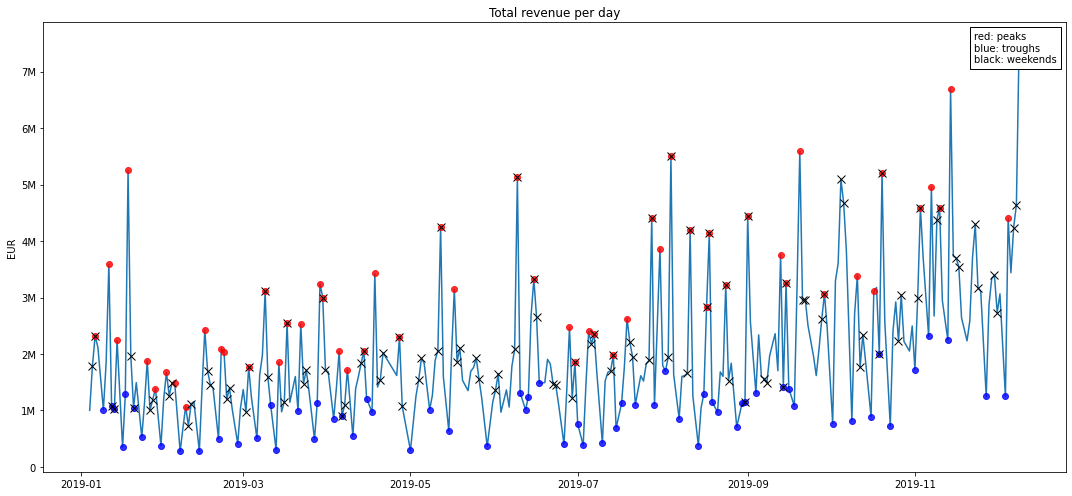

In [47]:
x = high_rev_dates ['invoice_date']
y = high_rev_dates ['total_revenue']

a = low_rev_dates ['invoice_date']
b = low_rev_dates ['total_revenue']

m = weekends_2019['invoice_date']
n = weekends_2019['total_revenue']


df_date_2019 = df_date [df_date['invoice_date'].dt.year == 2019]

fig, ax = plt.subplots(figsize = (15,7))
ax.plot (df_date_2019['invoice_date'], df_date_2019['total_revenue'], label = 'revenue')
for xy in zip (x,y):
    ax.plot(xy[0], xy[1], color = 'r', marker = 'o', label = 'high rev', alpha = 0.8)
    #plt.annotate(f'{xy[0].strftime("%d-%b")}', xy = xy)

for ab in zip (a,b):
    ax.plot(ab[0], ab[1], color = 'b', marker = 'o', alpha = 0.8)
    #plt.annotate(f'{ab[0].strftime("%d-%b")}', xy = ab)

for mn in zip (m,n):
    ax.plot(mn[0], mn[1], color = 'black', marker='x', markersize = 8, label = 'weekends')

at = AnchoredText ('red: peaks \nblue: troughs\nblack: weekends', frameon = True, loc = 'upper right')
ax.add_artist(at)

ax.set_yticks(ticks = list(range(0,8000000, 1000000)))
ax.set_yticklabels(labels = ['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
ax.set_ylabel('EUR')
plt.title('Total revenue per day')
plt.tight_layout()
plt.show()